## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [ ]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.0.0

In [2]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
import numpy as np
from torch.optim.lr_scheduler import StepLR
from torch import nn, optim
import warnings
from torch.functional import F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time 
import time, copy, glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from PIL import Image

warnings.filterwarnings("ignore")

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}


# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, num_workers=4, pin_memory=True, persistent_workers=True),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=4, pin_memory=True, persistent_workers=True)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(len(cat_to_name))

102


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
# TODO: Build and train your network

# Model Initialization
model = models.vgg16(pretrained=True)

# Freeze the feature parameters to avoid backpropagation through them
for param in model.parameters():
    param.requires_grad = False

# Define a new classifier
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 102),
    nn.LogSoftmax(dim=1)
)
model.classifier = classifier

# Set the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Optimization: For Gradient Accumulation
accumulation_steps = 4

# Optimization: Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Move the model to the appropriate device (MPS for Apple Mac, GPU for Nvidia, CPU otherwise)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 262MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# Training Configuration
epochs = 20
print_every = 50
steps = 0

# Early Stopping
best_val_loss = float('inf')
patience = 5
no_improve_epoch = 0

# Optimizer Configuration
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)


In [9]:
# Training the network

total_training_time = 0

for epoch in range(epochs):
    # Record the start time of the epoch
    start_time = time.time()
    
    running_loss = 0
    model.train()
    
    # Training loop
    train_bar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs} [Train]", position=0, leave=False, dynamic_ncols=True)
    for inputs, labels in train_bar:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()

        if steps % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

        if steps % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}.. Train loss: {running_loss/print_every:.3f}")
            running_loss = 0

    # Evaluation after each epoch
    valid_loss, accuracy = 0, 0
    model.eval()
    
    with torch.no_grad():
        valid_bar = tqdm(dataloaders['valid'], desc=f"Epoch {epoch+1}/{epochs} [Validate]", position=0, leave=False, dynamic_ncols=True)
        for inputs, labels in valid_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            valid_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    # Check if validation loss improved for early stopping
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss 
        no_improve_epoch = 0
    else:
        no_improve_epoch += 1

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Validation loss: {valid_loss/len(dataloaders['valid']):.3f}.. "
          f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")

    # Early stopping check
    if no_improve_epoch >= patience:
        print("Stopping early due to no improvement!")
        break

    # Step the learning rate scheduler
    scheduler.step(valid_loss)
    
    # Record the end time of the epoch
    end_time = time.time()
    
    # Calculate the time taken for the epoch
    epoch_time = end_time - start_time
    
    # Accumulate the time for all epochs
    total_training_time += epoch_time
    
    print(f"Epoch {epoch+1}/{epochs} took {epoch_time:.2f} seconds.")

# Print the total training time
print(f"Total training time: {total_training_time:.2f} seconds")
print("Training finished!")


Epoch 1/20 [Train]:  49%|████▊     | 50/103 [00:45<00:49,  1.07it/s]

Epoch 1/20.. Train loss: 7.726


Epoch 1/20 [Train]:  97%|█████████▋| 100/103 [01:23<00:01,  1.71it/s]

Epoch 1/20.. Train loss: 3.706


Epoch 1/20.. Validation loss: 2.527.. Validation accuracy: 0.438
Epoch 1/20 took 94.97 seconds.


Epoch 2/20 [Train]:  46%|████▌     | 47/103 [00:37<00:41,  1.36it/s]

Epoch 2/20.. Train loss: 2.577


Epoch 2/20 [Train]:  94%|█████████▍| 97/103 [01:14<00:03,  1.53it/s]

Epoch 2/20.. Train loss: 2.334


Epoch 2/20.. Validation loss: 1.389.. Validation accuracy: 0.634
Epoch 2/20 took 87.64 seconds.


Epoch 3/20 [Train]:  43%|████▎     | 44/103 [00:34<00:36,  1.62it/s]

Epoch 3/20.. Train loss: 1.716


Epoch 3/20 [Train]:  91%|█████████▏| 94/103 [01:14<00:09,  1.05s/it]

Epoch 3/20.. Train loss: 1.883


Epoch 3/20.. Validation loss: 1.057.. Validation accuracy: 0.721
Epoch 3/20 took 89.26 seconds.


Epoch 4/20 [Train]:  40%|███▉      | 41/103 [00:32<00:56,  1.11it/s]

Epoch 4/20.. Train loss: 1.411


Epoch 4/20 [Train]:  88%|████████▊ | 91/103 [01:10<00:09,  1.28it/s]

Epoch 4/20.. Train loss: 1.691


Epoch 4/20.. Validation loss: 0.887.. Validation accuracy: 0.749
Epoch 4/20 took 87.61 seconds.


Epoch 5/20 [Train]:  37%|███▋      | 38/103 [00:30<00:54,  1.19it/s]

Epoch 5/20.. Train loss: 1.164


Epoch 5/20 [Train]:  85%|████████▌ | 88/103 [01:08<00:09,  1.66it/s]

Epoch 5/20.. Train loss: 1.554


Epoch 5/20.. Validation loss: 0.784.. Validation accuracy: 0.785
Epoch 5/20 took 88.59 seconds.


Epoch 6/20 [Train]:  34%|███▍      | 35/103 [00:28<00:45,  1.49it/s]

Epoch 6/20.. Train loss: 1.072


Epoch 6/20 [Train]:  83%|████████▎ | 85/103 [01:07<00:18,  1.01s/it]

Epoch 6/20.. Train loss: 1.492


Epoch 6/20.. Validation loss: 0.743.. Validation accuracy: 0.790
Epoch 6/20 took 88.75 seconds.


Epoch 7/20 [Train]:  31%|███       | 32/103 [00:25<00:39,  1.80it/s]

Epoch 7/20.. Train loss: 0.910


Epoch 7/20 [Train]:  80%|███████▉  | 82/103 [01:03<00:16,  1.26it/s]

Epoch 7/20.. Train loss: 1.509


Epoch 7/20.. Validation loss: 0.672.. Validation accuracy: 0.819
Epoch 7/20 took 88.00 seconds.


Epoch 8/20 [Train]:  28%|██▊       | 29/103 [00:24<01:13,  1.01it/s]

Epoch 8/20.. Train loss: 0.783


Epoch 8/20 [Train]:  77%|███████▋  | 79/103 [01:01<00:16,  1.49it/s]

Epoch 8/20.. Train loss: 1.378


Epoch 8/20.. Validation loss: 0.626.. Validation accuracy: 0.841
Epoch 8/20 took 88.49 seconds.


Epoch 9/20 [Train]:  25%|██▌       | 26/103 [00:21<01:00,  1.27it/s]

Epoch 9/20.. Train loss: 0.665


Epoch 9/20 [Train]:  74%|███████▍  | 76/103 [00:58<00:16,  1.67it/s]

Epoch 9/20.. Train loss: 1.314


Epoch 9/20.. Validation loss: 0.585.. Validation accuracy: 0.840
Epoch 9/20 took 87.59 seconds.


Epoch 10/20 [Train]:  22%|██▏       | 23/103 [00:19<00:55,  1.43it/s]

Epoch 10/20.. Train loss: 0.553


Epoch 10/20 [Train]:  71%|███████   | 73/103 [00:56<00:24,  1.23it/s]

Epoch 10/20.. Train loss: 1.337


Epoch 10/20.. Validation loss: 0.588.. Validation accuracy: 0.846
Epoch 10/20 took 87.71 seconds.


Epoch 11/20 [Train]:  19%|█▉        | 20/103 [00:16<00:48,  1.70it/s]

Epoch 11/20.. Train loss: 0.522


Epoch 11/20 [Train]:  68%|██████▊   | 70/103 [00:54<00:25,  1.29it/s]

Epoch 11/20.. Train loss: 1.287


Epoch 11/20.. Validation loss: 0.526.. Validation accuracy: 0.857
Epoch 11/20 took 88.10 seconds.


Epoch 12/20 [Train]:  17%|█▋        | 17/103 [00:15<01:21,  1.05it/s]

Epoch 12/20.. Train loss: 0.432


Epoch 12/20 [Train]:  65%|██████▌   | 67/103 [00:51<00:23,  1.51it/s]

Epoch 12/20.. Train loss: 1.229


Epoch 12/20.. Validation loss: 0.485.. Validation accuracy: 0.877
Epoch 12/20 took 86.80 seconds.


Epoch 13/20 [Train]:  14%|█▎        | 14/103 [00:12<01:08,  1.30it/s]

Epoch 13/20.. Train loss: 0.327


Epoch 13/20 [Train]:  62%|██████▏   | 64/103 [00:49<00:27,  1.44it/s]

Epoch 13/20.. Train loss: 1.292


Epoch 13/20.. Validation loss: 0.585.. Validation accuracy: 0.851
Epoch 13/20 took 87.27 seconds.


Epoch 14/20 [Train]:  11%|█         | 11/103 [00:09<01:00,  1.53it/s]

Epoch 14/20.. Train loss: 0.262


Epoch 14/20 [Train]:  59%|█████▉    | 61/103 [00:46<00:39,  1.05it/s]

Epoch 14/20.. Train loss: 1.197


Epoch 14/20.. Validation loss: 0.573.. Validation accuracy: 0.840
Epoch 14/20 took 85.20 seconds.


Epoch 15/20 [Train]:   8%|▊         | 8/103 [00:07<00:59,  1.60it/s]

Epoch 15/20.. Train loss: 0.218


Epoch 15/20 [Train]:  56%|█████▋    | 58/103 [00:45<00:38,  1.16it/s]

Epoch 15/20.. Train loss: 1.227


Epoch 15/20.. Validation loss: 0.511.. Validation accuracy: 0.856
Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.
Epoch 15/20 took 86.49 seconds.


Epoch 16/20 [Train]:   5%|▍         | 5/103 [00:05<01:45,  1.07s/it]

Epoch 16/20.. Train loss: 0.127


Epoch 16/20 [Train]:  53%|█████▎    | 55/103 [00:42<00:32,  1.50it/s]

Epoch 16/20.. Train loss: 1.129


Epoch 16/20.. Validation loss: 0.461.. Validation accuracy: 0.883
Epoch 16/20 took 86.30 seconds.


Epoch 17/20 [Train]:   2%|▏         | 2/103 [00:03<02:31,  1.50s/it]

Epoch 17/20.. Train loss: 0.034


Epoch 17/20 [Train]:  50%|█████     | 52/103 [00:39<00:29,  1.74it/s]

Epoch 17/20.. Train loss: 1.040


Epoch 17/20.. Train loss: 0.978


Epoch 17/20.. Validation loss: 0.415.. Validation accuracy: 0.894
Epoch 17/20 took 86.36 seconds.


Epoch 18/20 [Train]:  48%|████▊     | 49/103 [00:38<00:48,  1.12it/s]

Epoch 18/20.. Train loss: 0.965


Epoch 18/20 [Train]:  96%|█████████▌| 99/103 [01:14<00:02,  1.43it/s]

Epoch 18/20.. Train loss: 0.980


Epoch 18/20.. Validation loss: 0.448.. Validation accuracy: 0.883
Epoch 18/20 took 86.37 seconds.


Epoch 19/20 [Train]:  45%|████▍     | 46/103 [00:36<00:50,  1.12it/s]

Epoch 19/20.. Train loss: 0.848


Epoch 19/20 [Train]:  93%|█████████▎| 96/103 [01:12<00:04,  1.48it/s]

Epoch 19/20.. Train loss: 0.896


Epoch 19/20.. Validation loss: 0.378.. Validation accuracy: 0.903
Epoch 19/20 took 85.92 seconds.


Epoch 20/20 [Train]:  42%|████▏     | 43/103 [00:33<00:38,  1.55it/s]

Epoch 20/20.. Train loss: 0.792


Epoch 20/20 [Train]:  90%|█████████ | 93/103 [01:10<00:09,  1.09it/s]

Epoch 20/20.. Train loss: 0.937


Epoch 20/20.. Validation loss: 0.357.. Validation accuracy: 0.909
Epoch 20/20 took 85.79 seconds.
Total training time: 1753.22 seconds
Training finished!


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
# TODO: Perform validation on the test set

correct = 0
total = 0

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Iterate through the test dataloader
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy on test images
accuracy = 100 * correct / total
print(f"Accuracy on test images: {accuracy:.2f}%")

Accuracy on test images: 89.38%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# TODO: Save the checkpoint 

def save_checkpoint(model, optimizer, epochs, class_to_idx, save_path):
    checkpoint = {
        'arch': 'vgg16',
        'classifier': model.classifier,
        'class_to_idx': class_to_idx,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epochs': epochs,
    }

    torch.save(checkpoint, save_path)

# Set the class_to_idx attribute
model.class_to_idx = image_datasets['train'].class_to_idx

# Specify the save path for the checkpoint
save_path = 'checkpoint1.pth'

# Save the checkpoint
save_checkpoint(model, optimizer, epochs, model.class_to_idx, save_path)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"Checkpoint file not found at: {filepath}")

    checkpoint = torch.load(filepath)
    
    # Use the same architecture as in the checkpoint
    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

    # Load the classifier, class_to_idx, and model state_dict
    model.classifier = checkpoint['classifier']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    # Create a new optimizer and load its state_dict
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # Retrieve the number of training epochs
    epochs = checkpoint['epochs']
    
    return model, optimizer, epochs

# Specify the path of the checkpoint
checkpoint_path = 'checkpoint1.pth'

# Load the checkpoint and rebuild the model
try:
    model, optimizer, epochs = load_checkpoint(checkpoint_path)
    print("Checkpoint loaded successfully.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")


Checkpoint loaded successfully.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a NumPy array
    '''
    
    # Load the image
    pil_image = Image.open(image_path)
    
    # Resize and crop the image to 224x224
    pil_image = pil_image.resize((256, 256))
    pil_image = pil_image.crop((16, 16, 240, 240))
    
    # Convert image to NumPy array and scale values to range [0, 1]
    np_image = np.array(pil_image) / 255.0
    
    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Reorder dimensions for PyTorch
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image_tensor, ax=None, title=None):
    """Display an image tensor using Matplotlib."""
    
    if ax is None:
        fig, ax = plt.subplots()

    # Convert the PyTorch tensor to a NumPy array and reorder dimensions
    image_np = image_tensor.numpy().transpose((1, 2, 0))

    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean

    # Clip values to be in the range [0, 1]
    image_np = np.clip(image_np, 0, 1)

    # Display the image
    ax.imshow(image_np)

    # Set the title if provided
    if title:
        ax.set_title(title)

    return ax


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image = torch.from_numpy(image).unsqueeze(0).float()
    
    # Check if GPU is available and if so, use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)
    
    with torch.no_grad():
        output = model.forward(image)
        probs, indices = torch.topk(output, topk)
        probs = probs.exp()
        
    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in indices.cpu().numpy()[0]]

    return probs.cpu().numpy()[0], top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [19]:
# TODO: Display an image along with the top 5 classes
def view_classify(image_path, probs, classes, mapper):
    ''' Function for viewing an image and its predicted classes.
    '''
    image = Image.open(image_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')

    y_pos = np.arange(len(probs))
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()  # probabilities from top to bottom

    plt.show()

Predictions:
pink primrose: 0.9232
tree mallow: 0.0419
hibiscus: 0.0314
mexican petunia: 0.0021
petunia: 0.0005


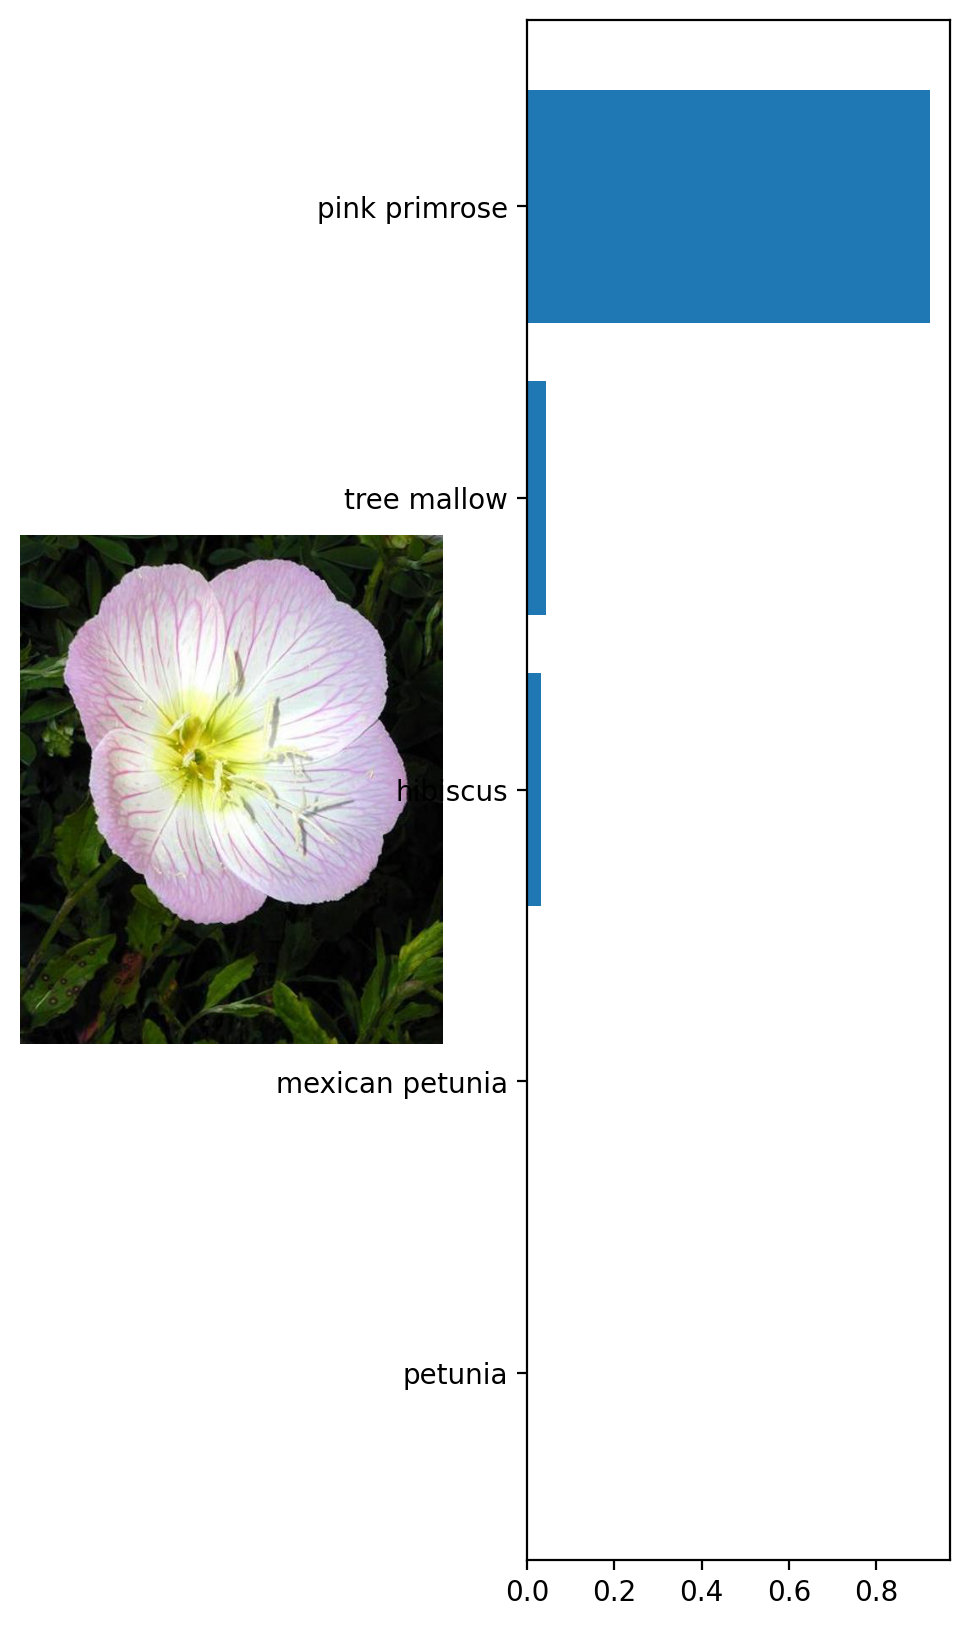

In [20]:
image_path = "flowers/test/1/image_06743.jpg"  # change this to the path of your image
# Get predictions
probs, classes = predict(image_path, model)

# Print predictions
print("Predictions:")
for prob, class_name in zip(probs, classes):
    print(f"{cat_to_name[class_name]}: {prob:.4f}")

# Show image and predictions
view_classify(image_path, probs, classes, cat_to_name)

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace